# Data From Bank Of England

Note: currency rates as well as interest rates are available

See https://www.bankofengland.co.uk/boeapps/database/

Helper blogs: https://www.datacareer.co.uk/blog/bank-of-england-s-statistical-interactive-database-iadb-using-python/ https://www.pythonsherpa.com/static/files/html/Bank%20of%20England.html

Yield curves not available in API, according to https://www.bankofengland.co.uk/statistics/yield-curves

```
The "SeriesCodes" parameter supports up to 300 comma separated codes in a single request.
The "CSVF" format parameter options are "TT" (Tabular with titles), "TN" (Tabular no titles), "CT" (Columnar with- titles) or "CN" (Columnar no titles).
The "VPD=Y" parameter need only be included if provisional data is desired.
```

In [1]:
import sys
import os
import datetime

import pandas as pd
import plotnine as p9

import io
import urllib
import shutil
import pathlib
import requests

In [2]:
daily_sonia_series_name = 'IUDSOIA'
treas_5_yr_nominal_par_yld = 'IUDSNPY'
treas_10_yr_nominal_par_yld = 'IUDMNPY'
treas_20_yr_nominal_par_yld = 'IUDLNPY'

yesterday = datetime.date.today() - datetime.timedelta(days=1)

yesterday_str = yesterday.strftime('%d/%b/%Y')
yesterday_str

'05/Feb/2025'

In [3]:
beng_url_endpoint = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'
beng_headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/54.0.2840.90 '
                  'Safari/537.36'
}
beng_payload_generic = {
    'Datefrom'   : '01/Jan/2000',
    'Dateto'     : yesterday_str,
    'CSVF'       : 'TN',
    'UsingCodes' : 'Y',
    'VPD'        : 'Y',
    'VFD'        : 'N'
}

In [4]:
series_codes = ','.join([
        
        daily_sonia_series_name, 
        treas_5_yr_nominal_par_yld,
        
    ])
series_codes

'IUDSOIA,IUDSNPY'

In [5]:
specific_payload = {'SeriesCodes':series_codes}
specific_payload.update( beng_payload_generic )
specific_payload

{'SeriesCodes': 'IUDSOIA,IUDSNPY',
 'Datefrom': '01/Jan/2000',
 'Dateto': '05/Feb/2025',
 'CSVF': 'TN',
 'UsingCodes': 'Y',
 'VPD': 'Y',
 'VFD': 'N'}

In [6]:
response = requests.get(
    beng_url_endpoint, 
    params=specific_payload, 
    headers=beng_headers)

assert str(response.status_code)=='200'

In [7]:
response.url

'https://www.bankofengland.co.uk/boeapps/database/_iadb-FromShowColumns.asp?csv.x=yes&SeriesCodes=IUDSOIA%2CIUDSNPY&Datefrom=01%2FJan%2F2000&Dateto=05%2FFeb%2F2025&CSVF=TN&UsingCodes=Y&VPD=Y&VFD=N'

In [8]:
beng_df = pd.read_csv(io.BytesIO(response.content))
print(beng_df.dtypes)
beng_df['date'] = pd.to_datetime(beng_df['DATE'])
beng_df.rename(columns={daily_sonia_series_name:'SONIA', treas_5_yr_nominal_par_yld:'5Y'}, inplace=True)
del beng_df['DATE']
beng_df.set_index('date', inplace=True)
beng_df.iloc[[0,1,2,-3,-2,-1]]

DATE        object
IUDSOIA    float64
IUDSNPY    float64
dtype: object


,SONIA,5Y
date,,
2000-01-04,4.5910,6.3171
2000-01-05,4.4584,6.3786
2000-01-06,4.9208,6.3921
2025-01-31,4.7037,4.1068
2025-02-03,4.7042,4.0639
2025-02-04,4.7049,4.1212


In [9]:
beng_plt_df = beng_df.unstack().reset_index().rename(columns={'level_0':'Tenor', 0:'Rate'})

/var/folders/2_/5mnc6wr90f52gfgzdkmj45mm0000gn/T/ipykernel_4209/3648751825.py:5: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


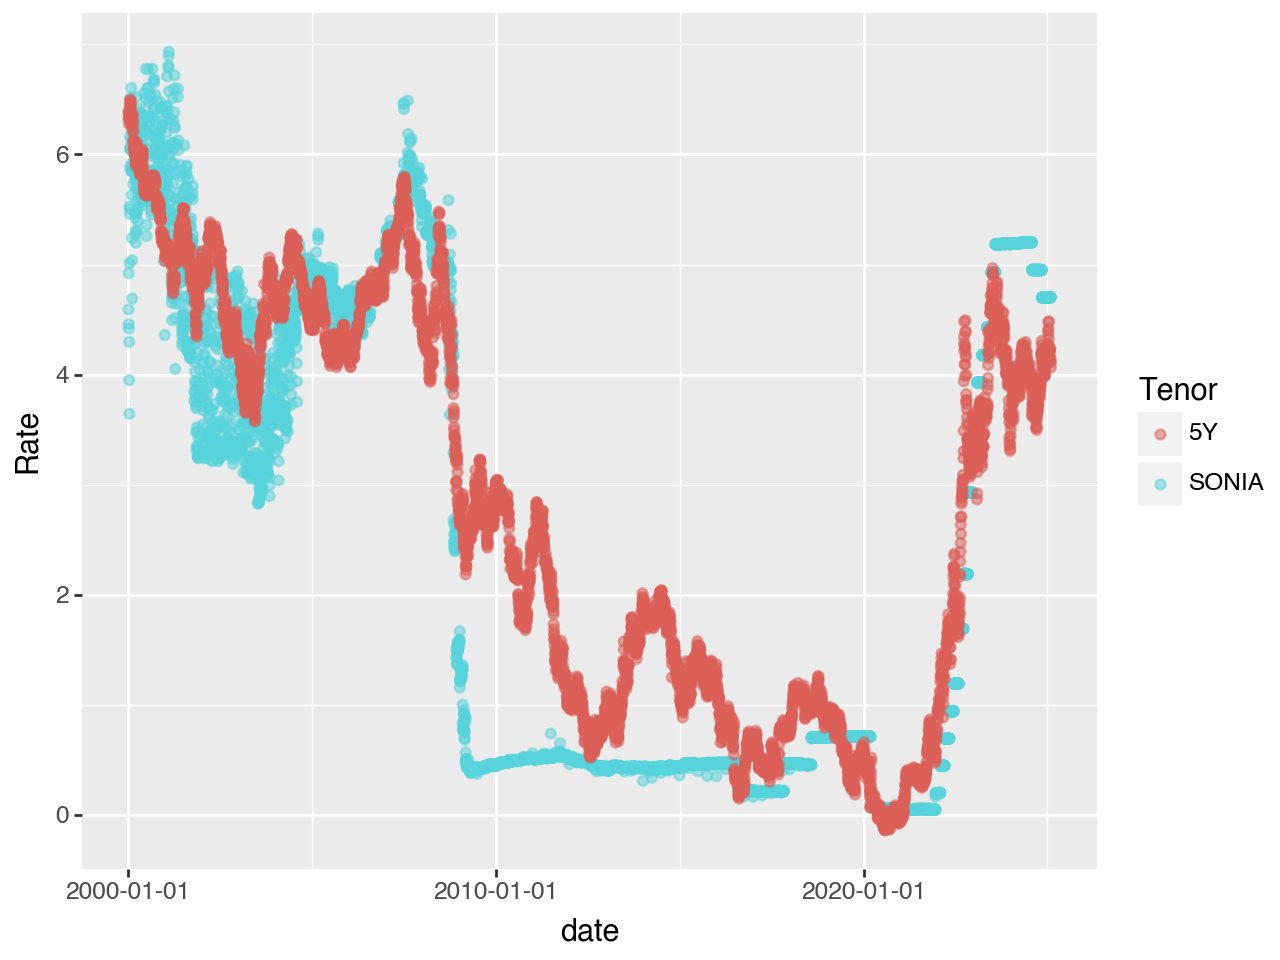

In [10]:
plt = (
    p9.ggplot(beng_plt_df, p9.aes(x='date', y='Rate', color='Tenor'))
    + p9.geom_point(alpha=0.5)
)
print(plt)